## ASTR 597A Homework 4 - Best viewed in dark mode (:
Eric Bellm

Due Jan 31, 2023

Your name: Tom Wagg
    
Your collaborators: Tobin Wainer

## Installation

This homework does not use the DP0.2 simulated data, and the `rubin_sim` package that includes the Metrics Analysis Framework (MAF) is not installed by default on `data.lsst.cloud`.  You may install and run `rubin_sim` on the `data.lsst.cloud` RSP instance, on your personal computer, or on a shared server like `epyc`.

You will need to install the `rubin_sim` package according to the directions at https://github.com/lsst/rubin_sim.

You can get more information about MAF from https://rubin-sim.lsst.io/ as well as the [rubin_sim_notebooks](https://github.com/lsst/rubin_sim_notebooks) tutorial notebooks; some of this material was adapted from those tutorials.

Note that in late 2022 many of the APIs in MAF were changed, as discussed in the [release notes](https://github.com/lsst/rubin_sim/releases), so you may find older materials which require some adjustment to use.

## Setup

Let's confirm that rubin_sim is working and that we can use MAF on the current baseline cadence.

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import os

%config InlineBackend.figure_format = "retina"

plt.style.use("dark_background")

In [205]:
import rubin_sim
from rubin_sim import maf
from rubin_sim.maf.run_comparison import archive

In [3]:
opsim_fname = rubin_sim.data.get_baseline()
print(opsim_fname)

/home/tomwagg/rubin_sim_data/sim_baseline/baseline_v3.0_10yrs.db


In [4]:
from os.path import splitext, basename

run_name = splitext(basename(opsim_fname))[0]
print(run_name)

baseline_v3.0_10yrs


## Exercise 1: Counts

Let's get a sense of how the LSST divides its exposures.  Use `UniSlicer`, `CountMetric`, and appropriate SQL constraints to provide counts of the total exposures by filter.  The OpSim schema is described [here](https://rubin-sim.lsst.io/rs_scheduler/output_schema.html).

In [8]:
# choose the spatial slicer
slicer = maf.slicers.UniSlicer()

# choose the metric
metric =  maf.metrics.CountMetric(col="numExposures")

out_dir = 'rubin_sim_outputs'

filter_exposures = np.zeros(6)

for i, filt in enumerate("ugrizy"):
    constraint = f"filter = '{filt}'"

    # wrap it up
    bundle = maf.metricBundles.MetricBundle(metric, slicer, constraint=constraint, run_name=run_name)

    bdict = {'q1':bundle}
    bgroup = maf.metricBundles.MetricBundleGroup(bdict, opsim_fname, out_dir=out_dir)
    bgroup.run_all()

    filter_exposures[i] = bdict["q1"].metric_values.astype(int)[0]

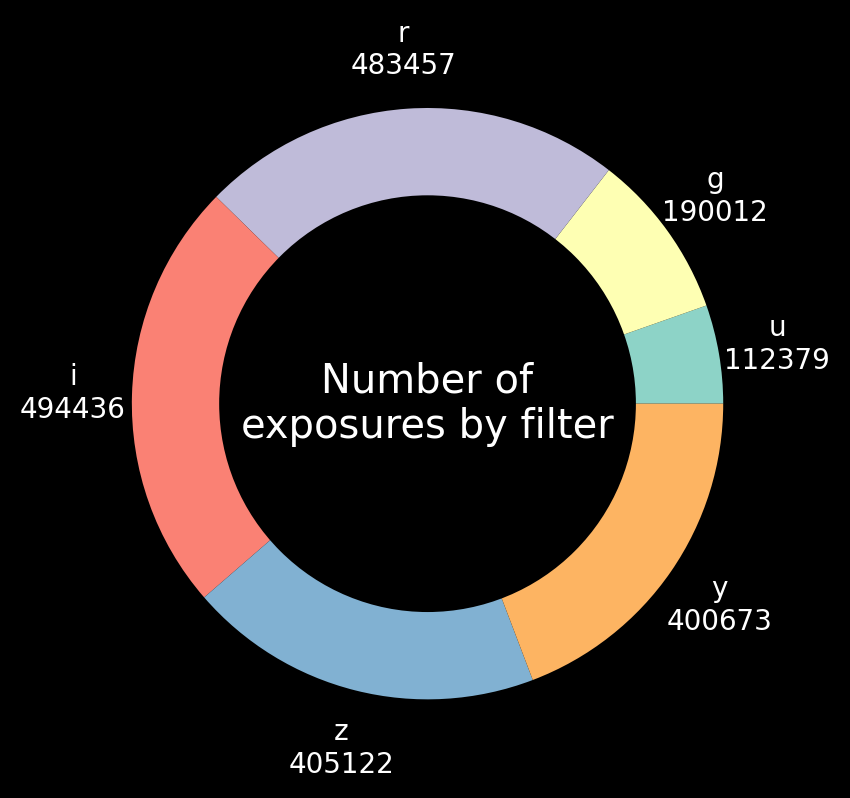

In [9]:
plt.pie(filter_exposures, labels=[f"{filt}\n{exp:1.0f}" for filt, exp in zip("ugrizy", filter_exposures)],
        textprops=dict(ha="center"), labeldistance=1.2)
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color="black"))
plt.annotate("Number of\nexposures by filter", xy=(0, 0), ha="center", va="center", fontsize="x-large")
plt.show()

## Exercise 2: Cloudy

What is the mean cloud cover for exposures taken during the simulated baseline survey?  Plot a histogram of the cloud cover.

In [10]:
# choose the spatial slicer
slicer = maf.slicers.UniSlicer()

# choose the metric
bins = np.linspace(0, 1, 30)
bin_centres = (bins[1:] + bins[:-1]) / 2
metric =  maf.metrics.HistogramMetric(bins=bins, bin_col="cloud", col="cloud", statistic="count")

out_dir = 'rubin_sim_outputs'

# wrap it up
bundle = maf.metricBundles.MetricBundle(metric, slicer, constraint=None, run_name=run_name,
                                        summary_metrics=[maf.metrics.MeanMetric()])

bdict = {'q2':bundle}
bgroup = maf.metricBundles.MetricBundleGroup(bdict, opsim_fname, out_dir=out_dir)
bgroup.run_all()

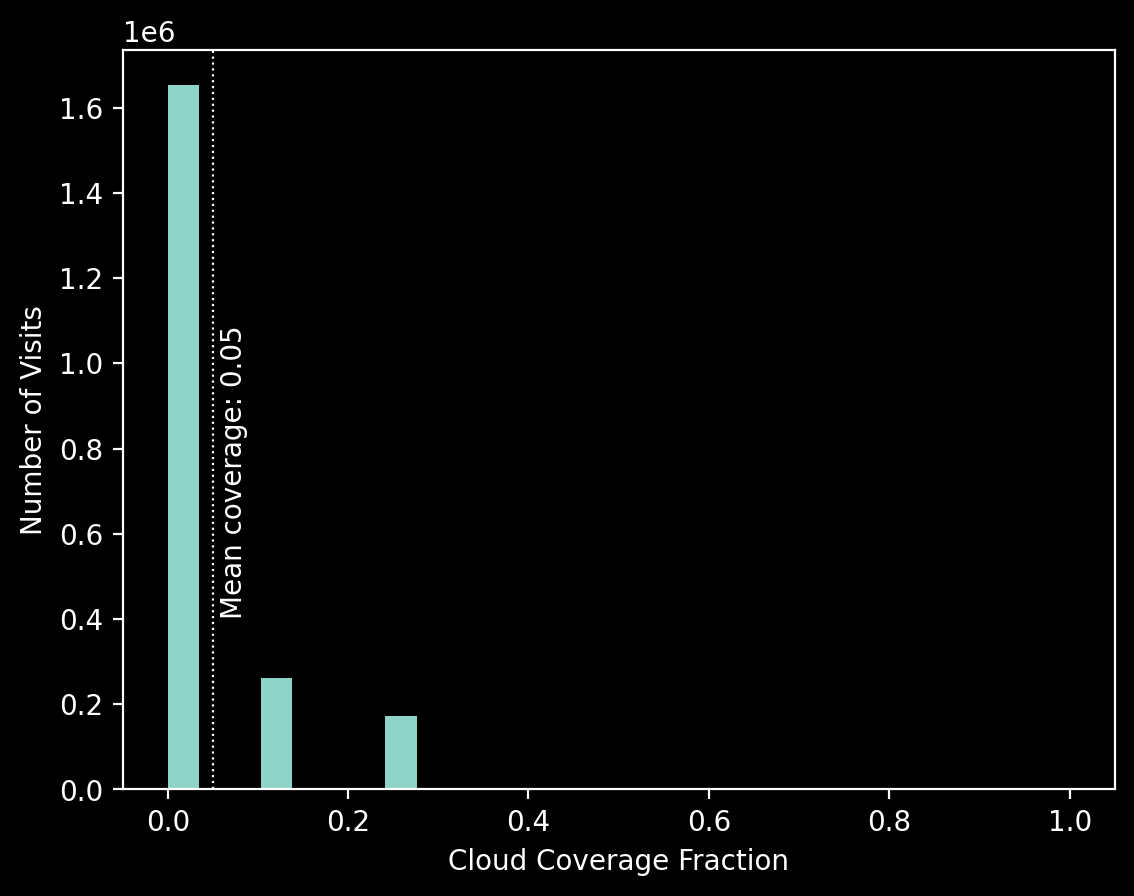

In [11]:
plt.stairs(bdict["q2"].metric_values[0], bins, fill=True)
plt.xlabel("Cloud Coverage Fraction")
plt.ylabel("Number of Visits")

mean_coverage = np.average(bin_centres, weights=bdict["q2"].metric_values[0])

plt.axvline(mean_coverage, color="white", linestyle="dotted", lw=0.8)
plt.annotate(f"Mean coverage: {mean_coverage:1.2f}", xy=(mean_coverage + 0.0075, 0.4e6), rotation=90,
             ha="left", va="bottom", fontsize="medium")

plt.show()

So we seem to just have 3 unique cloud fraction values because of some sort of weird simulation artifact. But we can note that most nights are completely cloud free (though this doesn't include nights that have no observations due to 100% cloud coverage)

## Exercise 3: Comparisons

MAF was built to compare evaluate the impact of different observing strategies on various science cases.  You can always write new metrics and run them yourself on multiple OpSim simulations.  This can be time consuming, though.  For many standard metrics, the metric values for various runs are stored in queryable tables--see the [04_Getting_Data](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/tutorial/04_Getting_Data.ipynb) tutorial notebook.

### 3a

In this exercise we'll get a small taste of the tradeoffs confronted by the Survey Cadence Optimization Committee.

Make a mesh plot of the metric summary values for the metric sets `"DESC WFD"` (Cosmology), `"TVS XRB"` (Galactic Transients), and `"SSO discovery"` (Solar System science) on run families `"baseline"`, `"galactic plane footprint"`, amd `"rolling"`.  Set `baseline_run='baseline_v2.0_10yrs'` to compare to one of the earlier baseline cadences.  Qualitatively, how does the new (v3.0) baseline cadence look for these metrics?  What other trends do you see across these run families?  

In [208]:
metric_sets = maf.get_metric_sets()
family_runs = maf.get_family_runs()
baseline_run = "baseline_v3.0_10yrs"

this_metric_set = ["DESC WFD", "TVS XRB", "SSO discovery"]
metric_label_map = metric_sets.loc[this_metric_set, "short_name"].droplevel(
    "metric set"
)

this_family = ["baseline", "galactic plane footprint", "rolling"]
run_label_map = family_runs.loc[this_family, ["run", "brief"]].set_index("run")["brief"]

# setting this manually because the actual label is ridiculously long
run_label_map.loc["baseline_v3.0_10yrs"] = "V3 baseline simulation"

summary = maf.get_metric_summaries(this_family, this_metric_set, run_order="family")

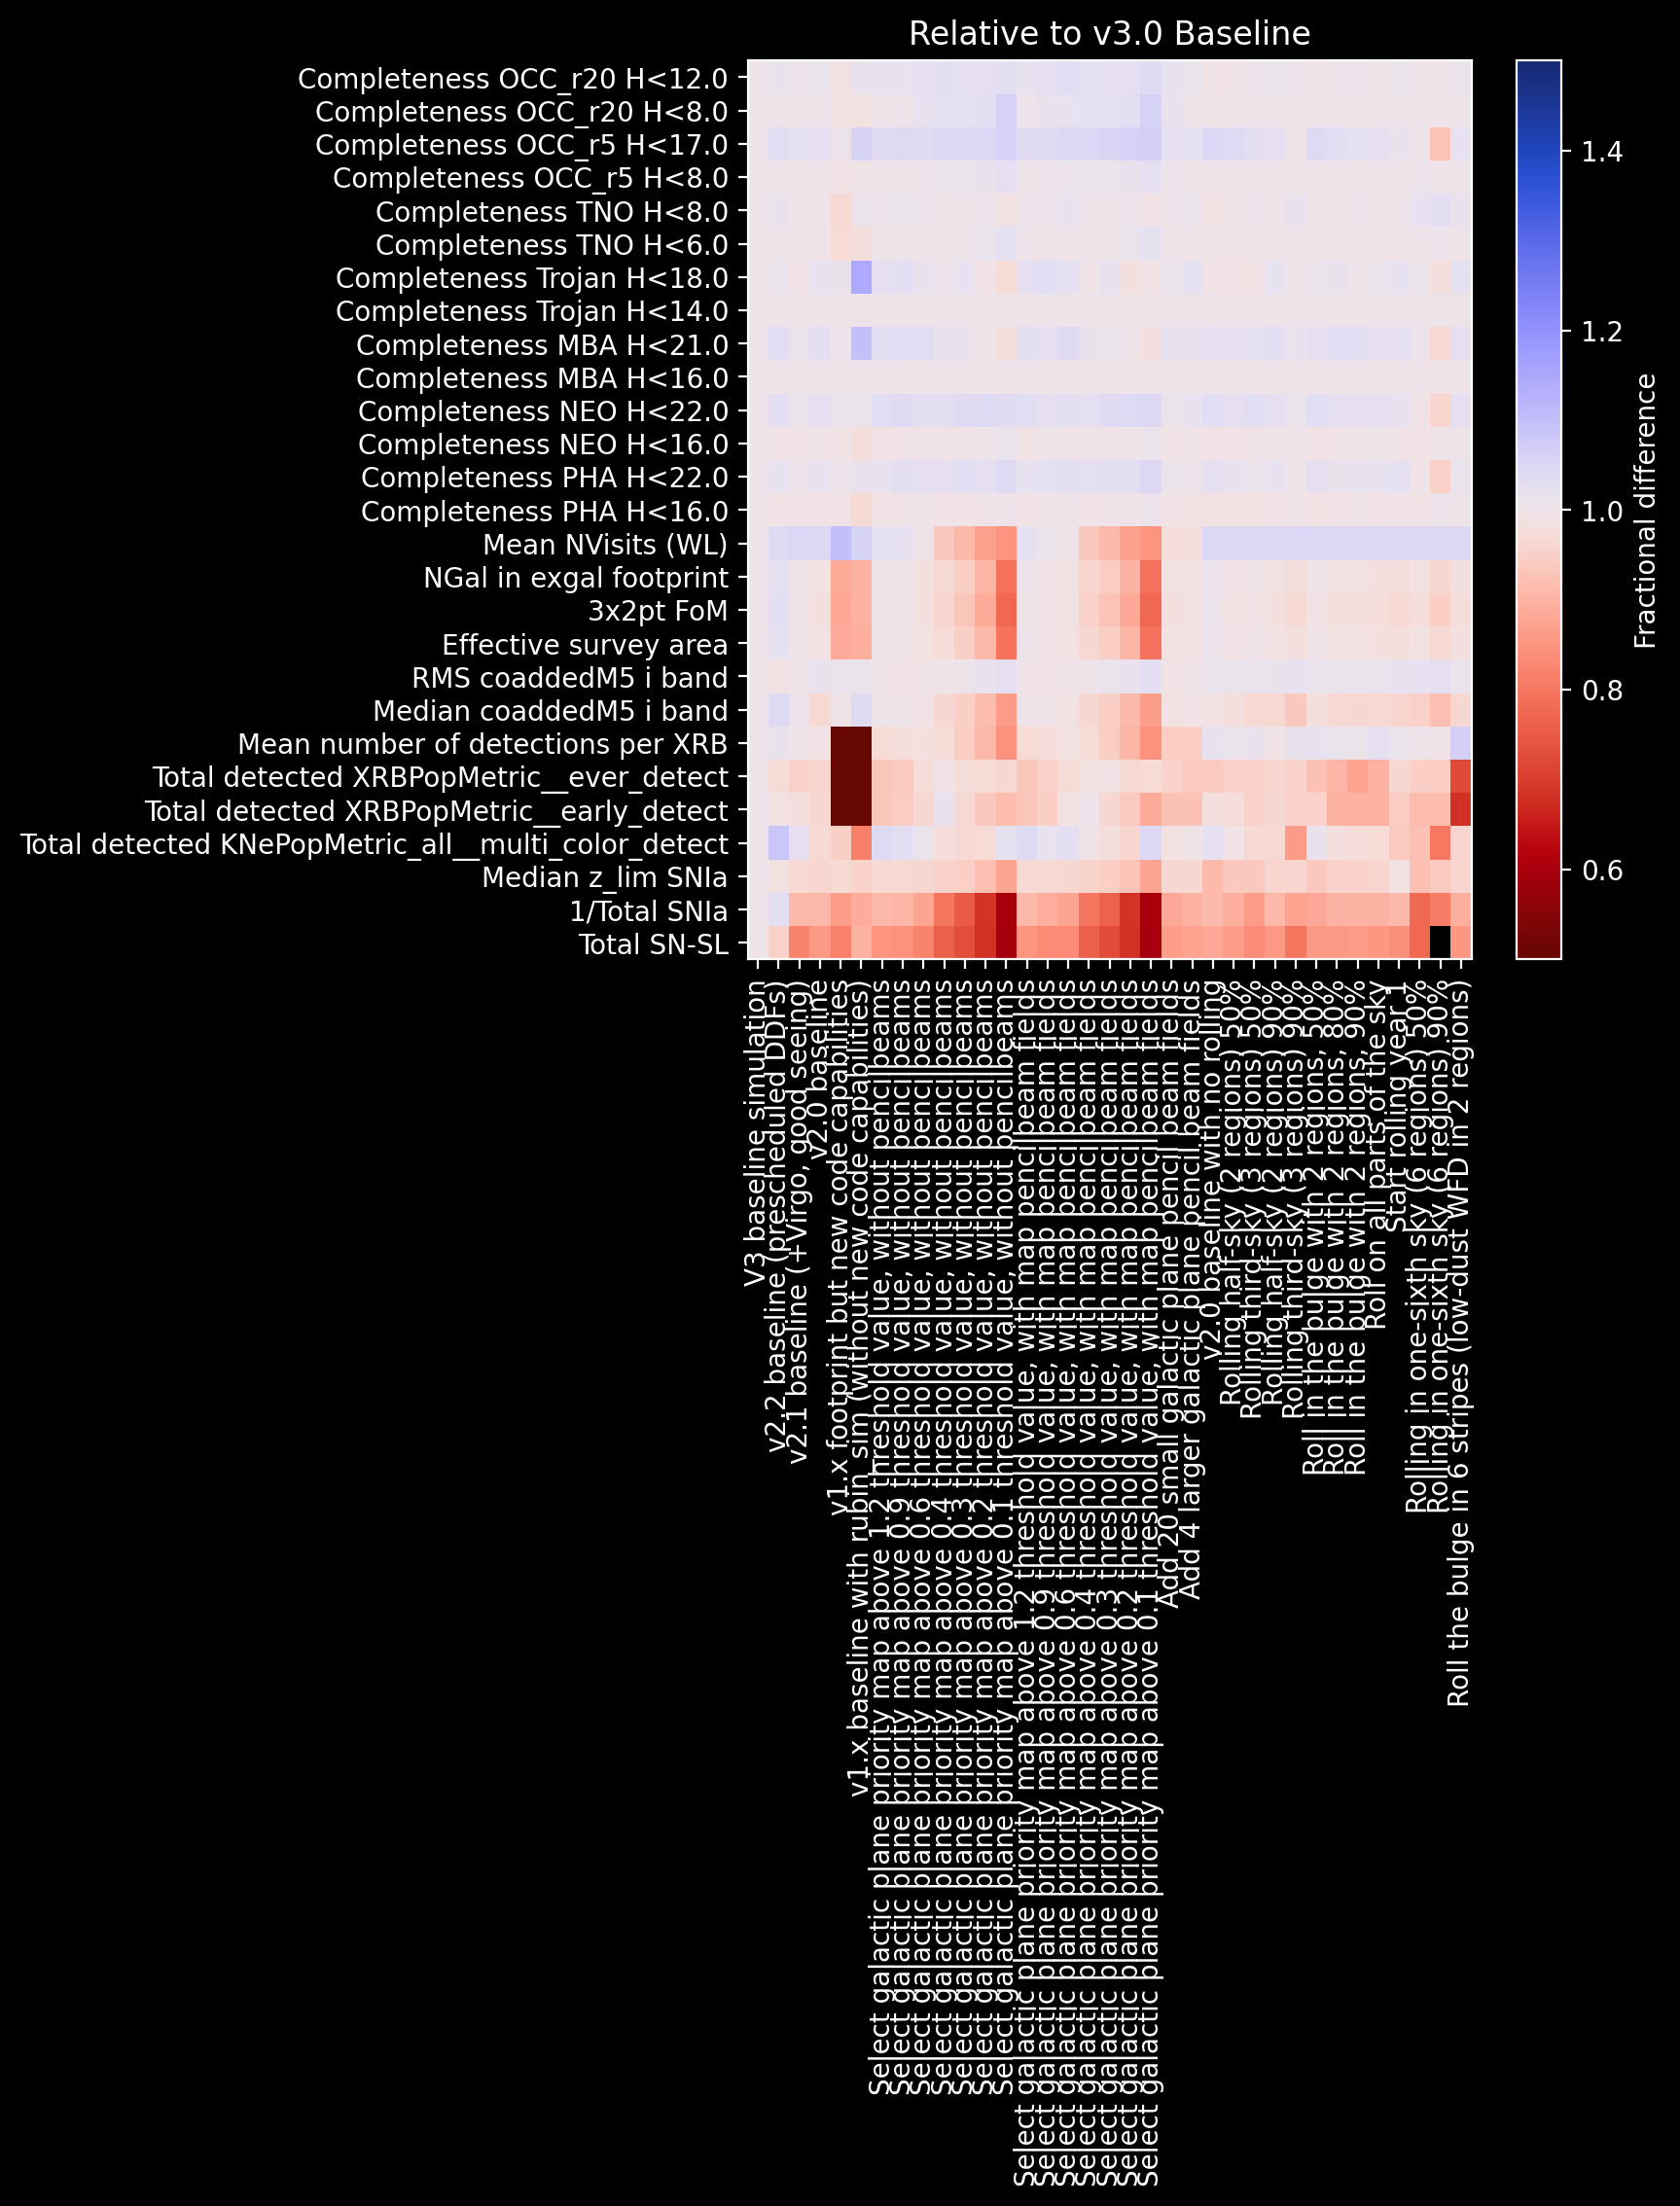

In [212]:
fig, ax = maf.plot_run_metric_mesh(
    summary,
    baseline_run=baseline_run,
    metric_set=metric_sets.loc[this_metric_set],
    run_label_map=run_label_map,
    metric_label_map=metric_label_map,
)
ax.set_title("Relative to v3.0 Baseline")
plt.show()

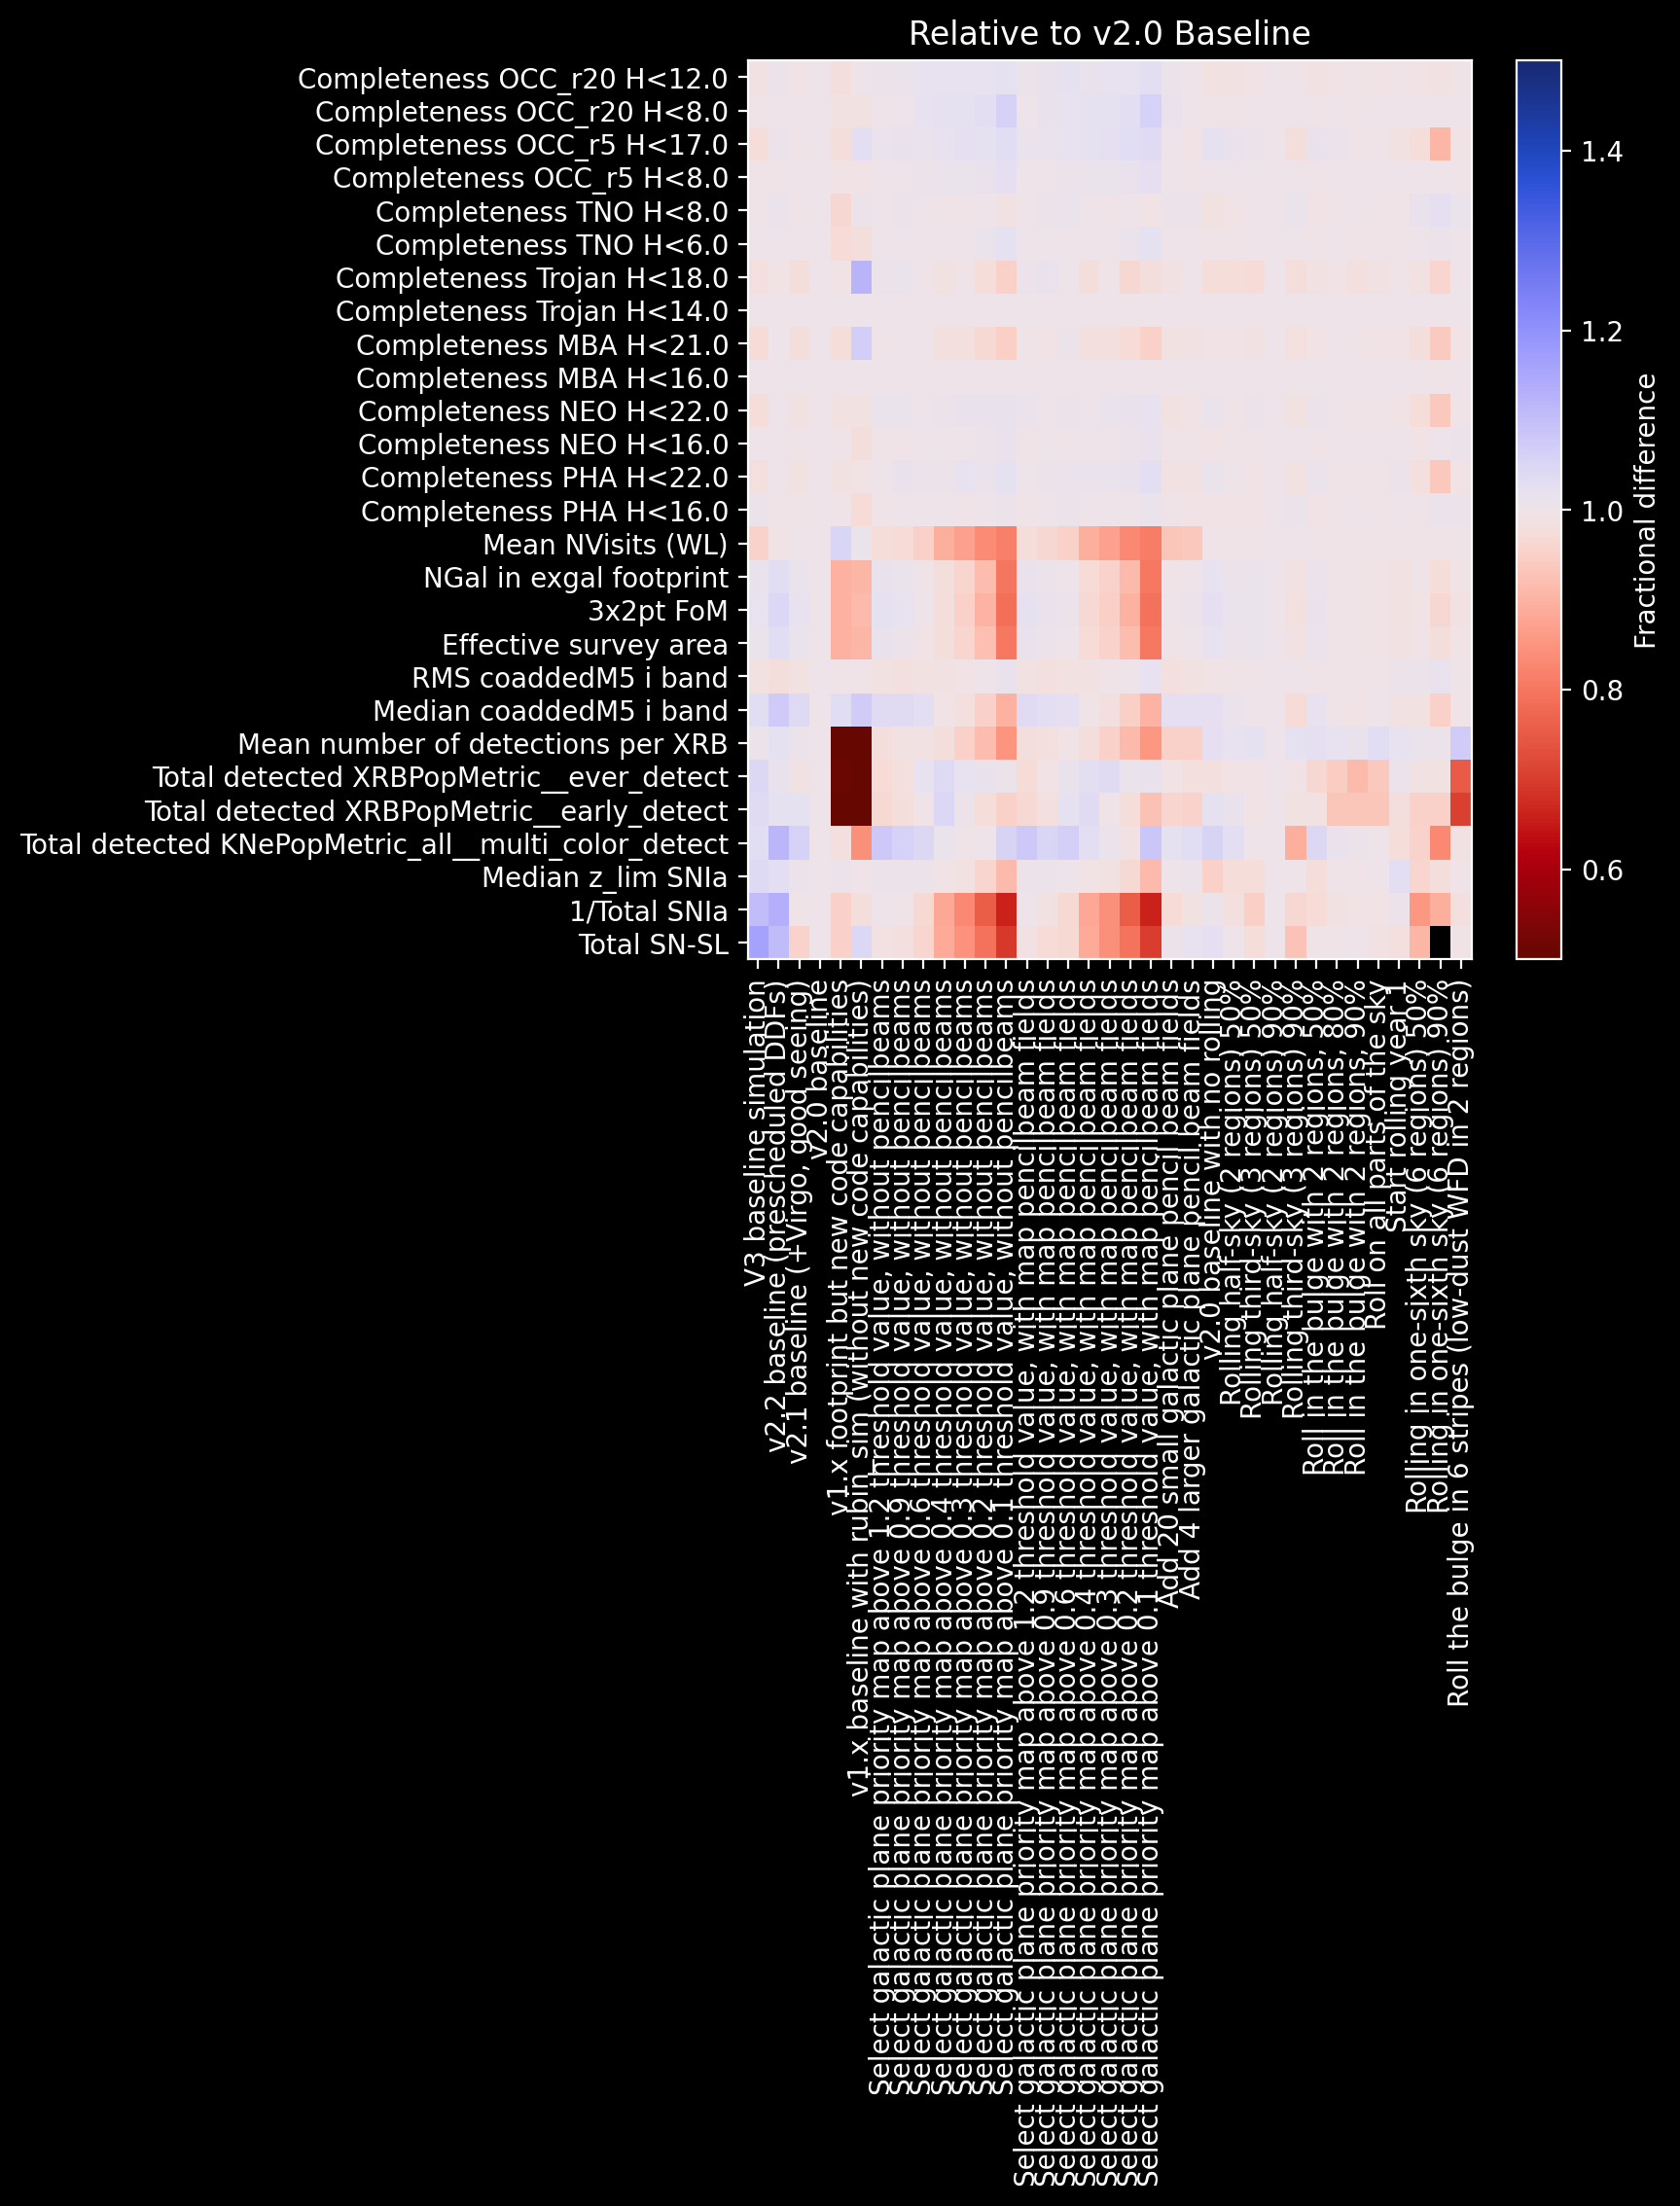

In [210]:
fig, ax = maf.plot_run_metric_mesh(
    summary,
    baseline_run="baseline_v2.0_10yrs",
    metric_set=metric_sets.loc[this_metric_set],
    run_label_map=run_label_map,
    metric_label_map=metric_label_map,
)
ax.set_title("Relative to v2.0 Baseline")
plt.show()

**v3.0 compared to other run families**: Broadly over these metrics it seems that v3.0 baseline cadence prioritises Galactic transients and Cosmology over SSO discovery compared to the other survey strategies. This is particularly stark for the total number of SNIa observations and various XRB metrics.

**v3.0 compared to earlier baselines**: The broad trends are similar to what I mentioned above but the improvement in XRB metrics since earlier baselines is particularly standout. However the faint Trojian and NEO detections have worsened in more recent baselines.

### 3b (optional)

Look through the list of metric sets and identify which one(s) are most closely associated with your scientific interests.  What has been the trend of these metrics in the `"baseline"` run family?  Make a plot with `maf.plot_run_metric`.

My LSST interests have mostly been in SSO discovery and NEOs in particular so we can just look at the plot above to see that. Interestingly it looks like the more recent baseline cadences have actually made the MBA, NEO and PHA metrics *worse* so I suppose something else is getting priority haha.

## Exercise 4: Lightcurves

Some metrics take simulated events and generate the data points as they would be observed by LSST.  Typically these lightcurves are only used internally to compute higher-level metrics, but some metrics make it possible to return the generated lightcurves.

Use the `KNePopMetric` with `output_lc=True` to generate random kilonova lightcurves as observed by LSST.  Plot an event with at least ten data points.

The [kilonova](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/KNeMetric.ipynb) and [XRB](https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/XRB_Metric.ipynb) science notebooks will be helpful.

In [271]:
n_events = 30000

# Kilonova parameters - set up to run on a particular subset of the KNe models
# All models
filename = maf.get_kne_filename(None)
slicer_all = maf.generate_kn_pop_slicer(n_events=n_events, n_files=len(filename), d_min=10, d_max=600)
metric_all = maf.KNePopMetric(output_lc=True, file_list=filename, metric_name='KNePopMetric_all')

In [272]:
baseline_file = rubin_sim.data.get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')

In [273]:
bundle_all = maf.MetricBundle(metric_all, slicer_all, constraint=None, 
                              info_label='all models', run_name=opsim, summary_metrics=summaryMetrics)

In [274]:
outDir = 'rubin_sim_outputs'
bdict = {'all': bundle_all}
g = maf.MetricBundleGroup(bdict, baseline_file, outDir)

In [136]:
g.run_all()

In [189]:
lc_ind = 0

metric_values = bdict["all"].metric_values.data[~bdict["all"].metric_values.mask]
potentially_nice_ones = []

for i in range(len(metric_values)):
    lc = metric_values[i]["lc"]
    n_mags = (lc[1] < 23).sum()
    if n_mags > 10 and (metric_values[i]["multi_detect"] >= 1):
        potentially_nice_ones.append(i)

In [275]:
def plot_kne(lc):
    bright_enough = lc[1] != 99

    kne_times = lc[0][bright_enough]
    kne_mags = lc[1][bright_enough]
    kne_filters = lc[-1][bright_enough]

    order = np.argsort(kne_times)
    kne_times = kne_times[order]
    kne_mags = kne_mags[order]
    kne_filters = kne_filters[order]

    for filt in "ugrizy":
        if filt in kne_filters:
            filt_mask = kne_filters == filt
            plt.scatter(kne_times[filt_mask] - kne_times.min(), kne_mags[filt_mask], label=filt)
    plt.title(f"Potential KNe Lightcurve")
    plt.xlabel(f"Time since {kne_times.min():1.2f} MJD")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

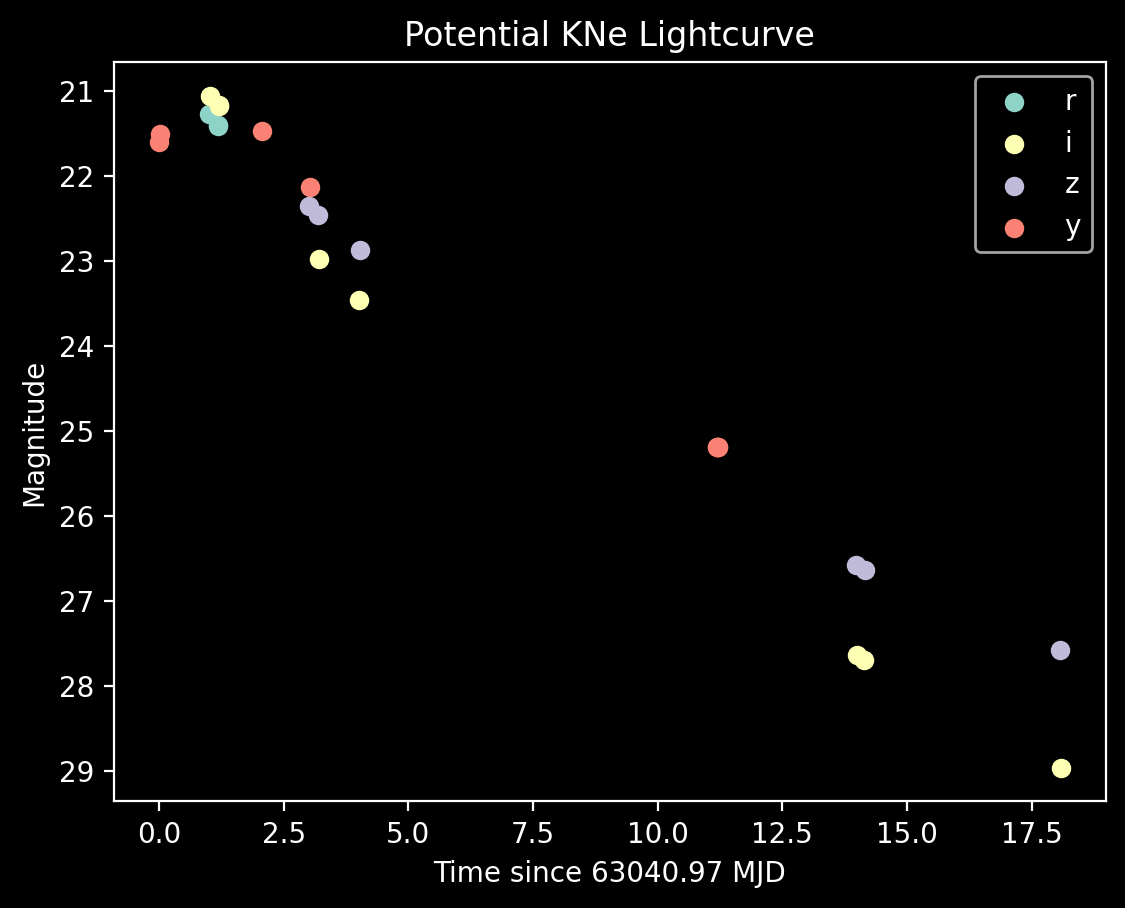

In [277]:
# I'm going to cheat and pick the one that looked most like a KNe from my list
for ind in [1993]:   # potentially_nice_ones:
    plot_kne(metric_values[ind]["lc"])

### Lightcurves should look like this

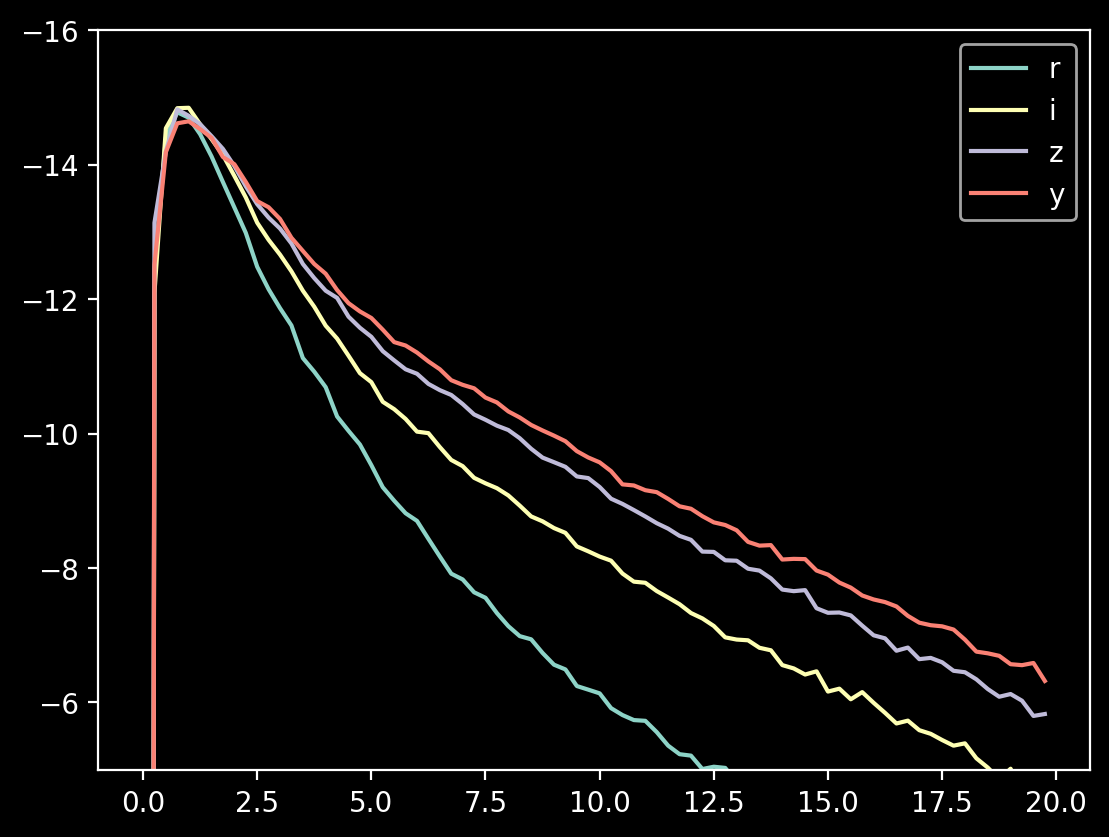

In [270]:
lcs = maf.KnLc(filename)
times = np.arange(0, 20, 0.25)

for j, f in enumerate('rizy'):
    mags = lcs.interp(times, f, lc_indx=3)
    plt.plot(times, mags, color=f"C{j}", label=f)

plt.ylim(-5, -16)

plt.legend()
plt.show()


Nice, that's not too different :)